In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

deals = pd.read_parquet('deals.parquet')
companies = pd.read_parquet('companies.parquet')
deals = deals.drop(['DealSynopsis', 'NativeCurrencyOfDeal', 'CompanyName', 'RowID', 'LastUpdated'], axis = 1)
deals_sorted = deals.sort_values(by=['CompanyID', 'DealNo'])

prelim_company = companies.drop(['FacebookProfileURL', 'TwitterProfileURL', 'LinkedInProfileURL',
       'PrimaryContactPBId', 'PrimaryContactFirstName',
       'PrimaryContactLastName', 'PrimaryContactMiddle',
       'PrimaryContactPrefix', 'PrimaryContactSuffix', 'PrimaryContact',
       'PrimaryContactTitle', 'RowID', 'CompanyAlsoKnownAs', 'CompanyFormerName',
       'CompanyLegalName', 'Description', 'Website', 'TotalRaisedNativeAmount', 'TotalRaisedNativeCurrency', 'DescriptionShort', 'FinancingStatusNote',
       'FinancingStatusNoteAsOfDate', 'Keywords', 'CompanyName', 'LastUpdated' 
       ], axis = 1)

df = pd.merge(deals, prelim_company, left_on= 'CompanyID', right_on= 'CompanyID', how = 'left')
df['ContingentPayout'].fillna(0, inplace= True)
df = df.sort_values(by=['CompanyID', 'DealNo'])

df.head()

/var/folders/h8/frp0f1bd0v32l04p93kbg3f00000gn/T/ipykernel_50789/108670608.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['ContingentPayout'].fillna(0, inplace= True)


,CompanyID,DealNo,DealDate,AnnouncedDate,DealSize,DealStatus,DealSizeStatus,PremoneyValuation,PostValuation,PostValuationStatus,...,OwnershipStatus,OwnershipStatusDate,Universe,Employees_y,EmployeeAsOfDate,Exchange,Ticker,YearFounded,ParentCompany,ParentCompanyID
25191,100022-14,1,2014-10-30,NaT,0.400000,Completed,Actual,NaN,NaN,None,...,Privately Held (backing),10/30/2014,"M&A, Venture Capital",52.0,11/24/2022,None,None,2014.0,None,None
24926,100022-14,2,2015-02-16,NaT,0.050000,Completed,Actual,NaN,NaN,None,...,Privately Held (backing),10/30/2014,"M&A, Venture Capital",52.0,11/24/2022,None,None,2014.0,None,None
23958,100022-14,3,2016-02-10,2015-09-01,1.175000,Completed,Actual,19.999999,21.174999,Actual,...,Privately Held (backing),10/30/2014,"M&A, Venture Capital",52.0,11/24/2022,None,None,2014.0,None,None
19779,100022-14,4,2018-12-26,NaT,2.999999,Completed,Actual,35.000000,37.999999,Actual,...,Privately Held (backing),10/30/2014,"M&A, Venture Capital",52.0,11/24/2022,None,None,2014.0,None,None
17480,100022-14,5,2020-01-22,2019-06-15,5.099998,Completed,Actual,40.000000,45.099998,Actual,...,Privately Held (backing),10/30/2014,"M&A, Venture Capital",52.0,11/24/2022,None,None,2014.0,None,None


## Preprocessing 

In [33]:
# maps, functions etc
deal_class_order = {
   'Out of Business': -1,
   'Bankruptcy': -1,
   'Other': 1,
   'Individual': 2,
   'Venture Capital': 3, 
   'Debt': 4,
   'Corporate': 5,
   'Private Equity': 6,
   'Public Investment': 7,
   'Hedge Fund': 8
}

# for ordering funding stages (series A, AA, A1, B1)
def order_letters_and_nums(x):
    if x == '1' or x=='2' or x=='3':
        return 1
    elif x == 'Angel' or x == 'Seed':
        return 0
    elif x is None:
        return None
    else:
        return sorted([i for i in df['funding_stages'].unique() if i not in [None,'1', '2', '3']]).index('A') + 2

# for binning business status
def business_status_bins(x):
    if x in ['Startup', 'Stealth', 'Product In Beta Test', 'Product Development', 'Product In Beta Test', 'Pre-Clinical Trials']:
        return 1
    elif x in ['Clinical Trials - Phase 1', 'Clinical Trials - Phase 2', 'Clinical Trials - Phase 3', 'Clinical Trials - Phase 4']:
        return 2
    elif x in ['Restart', 'Bankruptcy: Admin/Reorg']:
        return 0
    elif x in ['Generating Revenue', 'Generating Revenue/Not Profitable']:
        return 3
    elif x in ['Profitable']:
        return 4
    elif x in ['Out of Business', 'Bankruptcy: Liquidation']:
        return -1
    else:
        return np.nan
    
# for ordering vc rounds
def encode_VCRounds(x):
     if pd.isnull(x):
        return -1
     elif x == 'Angel':
        return 0
     else:
         return int(x.split()[0].rstrip('stndrdth'))

In [34]:
# features from the past
df['Prev_DealSize'] = df.groupby('CompanyID')['DealSize'].shift(1)
df['Prev_RaisedToDate'] = df.groupby('CompanyID')['RaisedToDate'].shift(1)
df['Prev_TotalInvestedCapital'] = df.groupby('CompanyID')['TotalInvestedCapital'].shift(1)
df['Prev_TotalInvestedEquity']= df.groupby('CompanyID')['TotalInvestedEquity'].shift(1)
df['Prev_PostValuation']= df.groupby('CompanyID')['PostValuation'].shift(1)

# 1 if there exists parent company else 0
df['is_ParentCompany']= df['ParentCompany'].notna()

# feature to represent funding stages
df['funding_stages']= df['DealType2'].apply(lambda x: None if x is None else (x.split()[1][0] if 'Series' in x.split() else ('Angel' if 'Angel' in x.split() else ('Seed' if 'Seed' in x.split() else None))))
df['funding_stages'] = df['funding_stages'].apply(order_letters_and_nums)

# impute deal class
df.loc[(df['DealClass'].isna()) & (df['DealType'] == 'Platform Creation'), 'DealClass'] = 'Private Equity'
df.loc[df['DealClass'].isna(), 'DealClass'] = 'Other'

# give orders to deal class
df['DealClass_order'] = df['DealClass'].map(deal_class_order)

# imputing debt
df.loc[df['DebtRaisedInRound'].isna() & df['Debts'].isna(), 'DebtRaisedInRound'] = 0

# deal class one hot encoding
lb = LabelBinarizer()
lb.fit_transform(df['DealClass'])
encode_DealClass = pd.DataFrame(lb.fit_transform(df['DealClass']),
    columns=[f'DealClass_{label}' for label in lb.classes_],
    index= df.index
)
df = pd.concat([df, encode_DealClass], axis=1)

# feature to represent vc rounds
df['VCRound'] = df['VCRound'].apply(encode_VCRounds)
df['AddOn'] = df['AddOn'].apply(lambda x: x == 'Yes')

# business status ORDER
df['BusinessStatus_x_ordinal'] = df['BusinessStatus_x'].map(business_status_bins)

# business status one hot encoding
lb = LabelBinarizer()
lb.fit_transform(df['BusinessStatus_x'].fillna('NA'))
encode_BusinessStatus_x = pd.DataFrame(lb.fit_transform(df['BusinessStatus_x'].fillna('NA')),
    columns=[f'BusinessStatus_x_{label}' for label in lb.classes_],
    index= df.index
)
df = pd.concat([df, encode_BusinessStatus_x], axis=1)

# financing status one hot encoding
lb = LabelBinarizer()
lb.fit_transform(df['FinancingStatus'].fillna('NA'))
encode_FinancingStatus = pd.DataFrame(lb.fit_transform(df['FinancingStatus'].fillna('NA')),
    columns=[f'FinancingStatus_{label}' for label in lb.classes_],
    index= df.index
)
df = pd.concat([df, encode_FinancingStatus], axis=1)

# ownership status one hot encoding
lb = LabelBinarizer()
lb.fit_transform(df['OwnershipStatus'].fillna('NA'))
encode_OwnershipStatus = pd.DataFrame(lb.fit_transform(df['OwnershipStatus'].fillna('NA')),
    columns=[f'OwnershipStatus_{label}' for label in lb.classes_],
    index= df.index
)
df = pd.concat([df, encode_OwnershipStatus], axis=1)

# encoding universe
mlb = MultiLabelBinarizer()
encode_Universe = pd.DataFrame( mlb.fit_transform(df['Universe'].apply(lambda x: [i.strip() for i in x.split(',')])),
    columns=[f'is_{label}' for label in mlb.classes_],
    index= df.index
)
df = pd.concat([df, encode_Universe], axis=1)


## Random Forest Model

In [36]:

data = df.dropna(subset = ['PostValuation'])
X = data[[
'DealSize', 
    'RaisedToDate',
  'TotalInvestedCapital',
  'InvestorOwnership',
  'TotalInvestedEquity',
  'TotalNewDebt',
 'DebtRaisedInRound',
  'TotalRaised',
  'YearFounded', 'ContingentPayout',
  'Prev_DealSize', 
       'Prev_RaisedToDate', 'Prev_TotalInvestedCapital',
       'Prev_TotalInvestedEquity', 'Prev_PostValuation',
'is_Debt Financed', 'is_M&A','is_Other Private Companies', 'is_Pre-venture',	'is_Private Equity', 'is_Publicly Listed','is_Venture Capital',
'AddOn', 
 'DealClass_order', 
'BusinessStatus_x_ordinal',
'VCRound',
   'FinancingStatus_Accelerator/Incubator Backed',
       'FinancingStatus_Angel-Backed',
         'FinancingStatus_Corporate or Acquired',
       'FinancingStatus_Corporation',
       'FinancingStatus_Failed Transaction (Angel)',
       'FinancingStatus_Failed Transaction (M&A)',
       'FinancingStatus_Failed Transaction (PE)',
       'FinancingStatus_Failed Transaction (VC)',
       'FinancingStatus_Formerly Accelerator/Incubator backed',
       'FinancingStatus_Formerly Angel backed',
       'FinancingStatus_Formerly PE-Backed',
       'FinancingStatus_Formerly Private Debt Financed',
       'FinancingStatus_Formerly VC-backed', 'FinancingStatus_NA',
       'FinancingStatus_Pending Transaction (Angel)',
       'FinancingStatus_Pending Transaction (Debt)',
       'FinancingStatus_Pending Transaction (M&A)',
       'FinancingStatus_Pending Transaction (PE)',
       'FinancingStatus_Pending Transaction (VC)',
       'FinancingStatus_Potential Target',
       'FinancingStatus_Private Debt Financed',
       'FinancingStatus_Private Equity-Backed',
       'FinancingStatus_Venture Capital-Backed',
      'is_ParentCompany',
       'OwnershipStatus_Acquired/Merged',
       'OwnershipStatus_Acquired/Merged (Operating Subsidiary)',
       'OwnershipStatus_In IPO Registration',
       'OwnershipStatus_Out of Business',
       'OwnershipStatus_Privately Held (backing)',
       'OwnershipStatus_Privately Held (no backing)',
       'OwnershipStatus_Publicly Held',
        'funding_stages'
 ]]
y = np.log1p(data['PostValuation']) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
print(rf.score(X_test, y_test))

0.9272398660607529


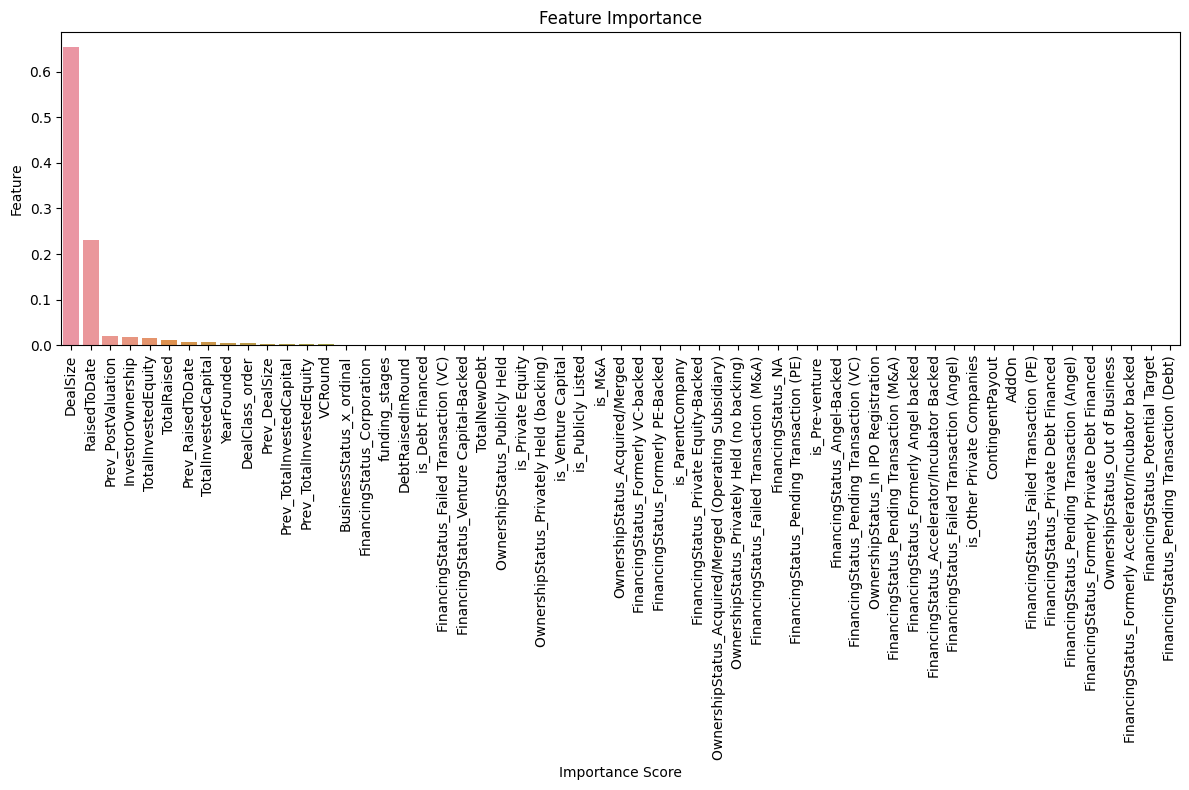

In [55]:
plt.figure(figsize=(12, 8))
feature_importance = pd.DataFrame({"Scores": rf.feature_importances_, 'Feature': X.columns}).sort_values('Scores', ascending=False).reset_index().drop('index', axis=1)
sns.barplot(y='Scores', x='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.xticks(rotation=90) 
plt.tight_layout()
plt.show()


From the feature importance scores, we can see that there are many irrelevant predictos. The one-hot encoded variables for financing status, universe and ownership status does not seem to explain the variability in PostValuation. Other variables like AddOn and ContingentPayout will be removed as well.

In [ ]:

data = df.dropna(subset = ['PostValuation'])
X = data[[
'DealSize', 'RaisedToDate','TotalInvestedCapital',
  'InvestorOwnership','TotalInvestedEquity','TotalNewDebt','DebtRaisedInRound',
  'TotalRaised','YearFounded', 'Prev_DealSize', 'Prev_RaisedToDate', 'Prev_TotalInvestedCapital', 'Prev_TotalInvestedEquity', 'Prev_PostValuation',
 'DealClass_order', 'BusinessStatus_x_ordinal','VCRound','funding_stages'
 ]]
y = np.log1p(data['PostValuation']) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
print(rf.score(X_test, y_test))

0.9272665470683109


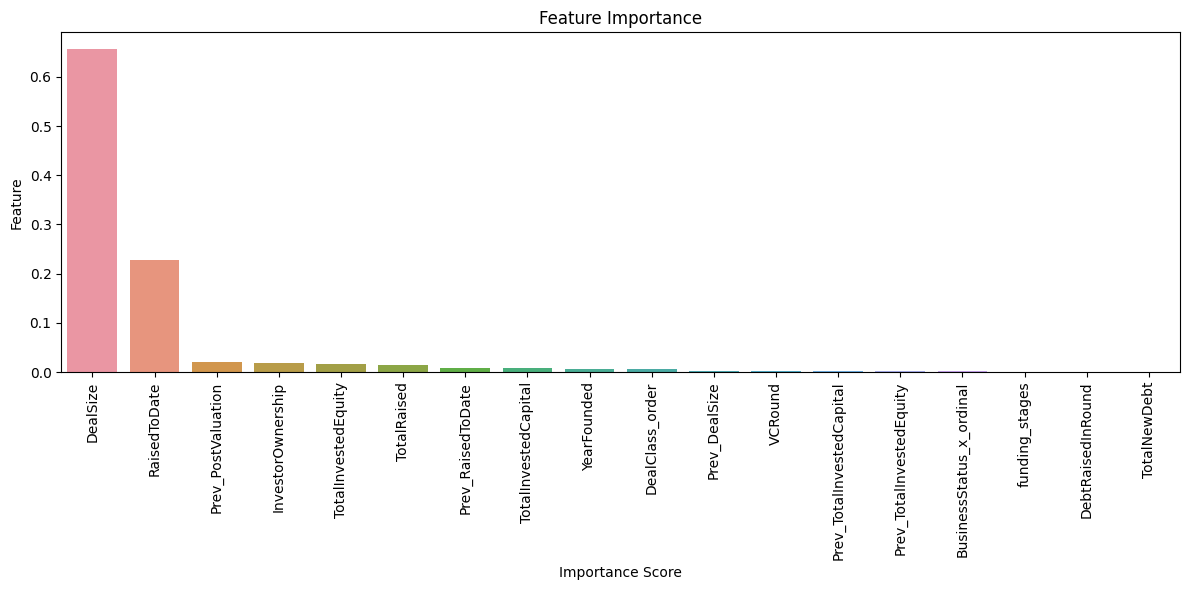

In [66]:
plt.figure(figsize=(12, 6))
feature_importance = pd.DataFrame({"Scores": rf.feature_importances_, 'Feature': X.columns}).sort_values('Scores', ascending=False).reset_index().drop('index', axis=1)
sns.barplot(y='Scores', x='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.xticks(rotation=90) 
plt.tight_layout()
plt.show()


In [79]:
rf = RandomForestRegressor()
param_grid = {
    'n_estimators': [200, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2,5],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt', None],
    'criterion': ["friedman_mse",'squared_error']
}

grid_search = GridSearchCV(estimator=rf,param_grid=param_grid,cv=5, n_jobs=-1,verbose=0)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'criterion': ['friedman_mse', 'squared_error'],
                         'max_depth': [None, 10, 20, 30],
                         'max_features': ['sqrt', None],
                         'min_samples_leaf': [2], 'min_samples_split': [5],
                         'n_estimators': [500, 600, 700]})

In [83]:
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'criterion': 'squared_error', 'max_depth': 30, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 500}
Best Score: 0.9315598980010682


In [88]:
rf_final = RandomForestRegressor(criterion= 'squared_error', max_depth=30, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators= 500)
rf_final.fit(X_test, y_test)
y_pred = rf_final.predict(X_test)

print('Final Score:', rf_final.score(X_test, y_test))
print('Final RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

Final Score: 0.9761266384902338
Final RMSE: 0.2692823156111338


## XGBoost

In [110]:
from xgboost import XGBRegressor
xgb = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

data = df.dropna(subset = ['PostValuation'])
X = data[[
'DealSize', 
    'RaisedToDate',
  'TotalInvestedCapital',
  'InvestorOwnership',
  'TotalInvestedEquity',
  'TotalNewDebt',
 'DebtRaisedInRound',
  'TotalRaised',
  'YearFounded', 'ContingentPayout',
  'Prev_DealSize', 
       'Prev_RaisedToDate', 'Prev_TotalInvestedCapital',
       'Prev_TotalInvestedEquity', 'Prev_PostValuation',
'is_Debt Financed', 'is_M&A','is_Other Private Companies', 'is_Pre-venture',	'is_Private Equity', 'is_Publicly Listed','is_Venture Capital',
'AddOn', 
 'DealClass_order', 
'BusinessStatus_x_ordinal',
'VCRound',
   'FinancingStatus_Accelerator/Incubator Backed',
       'FinancingStatus_Angel-Backed',
       'FinancingStatus_Corporation',
       'FinancingStatus_Failed Transaction (Angel)',
       'FinancingStatus_Failed Transaction (M&A)',
       'FinancingStatus_Failed Transaction (PE)',
       'FinancingStatus_Failed Transaction (VC)',
       'FinancingStatus_Formerly Accelerator/Incubator backed',
       'FinancingStatus_Formerly Angel backed',
       'FinancingStatus_Formerly PE-Backed',
       'FinancingStatus_Formerly Private Debt Financed',
       'FinancingStatus_Formerly VC-backed', 'FinancingStatus_NA',
       'FinancingStatus_Pending Transaction (Angel)',
       'FinancingStatus_Pending Transaction (Debt)',
       'FinancingStatus_Pending Transaction (M&A)',
       'FinancingStatus_Pending Transaction (PE)',
       'FinancingStatus_Pending Transaction (VC)',
       'FinancingStatus_Potential Target',
       'FinancingStatus_Private Debt Financed',
       'FinancingStatus_Private Equity-Backed',
       'FinancingStatus_Venture Capital-Backed',
      'is_ParentCompany',
       'OwnershipStatus_Acquired/Merged',
       'OwnershipStatus_Acquired/Merged (Operating Subsidiary)',
       'OwnershipStatus_In IPO Registration',
       'OwnershipStatus_Out of Business',
       'OwnershipStatus_Privately Held (backing)',
       'OwnershipStatus_Privately Held (no backing)',
       'OwnershipStatus_Publicly Held',
        'funding_stages'
 ]]
y = np.log1p(data['PostValuation']) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=-1, num_parallel_tree=None, ...)

In [94]:
xgb.score(X_test, y_test)

0.9324311638471463

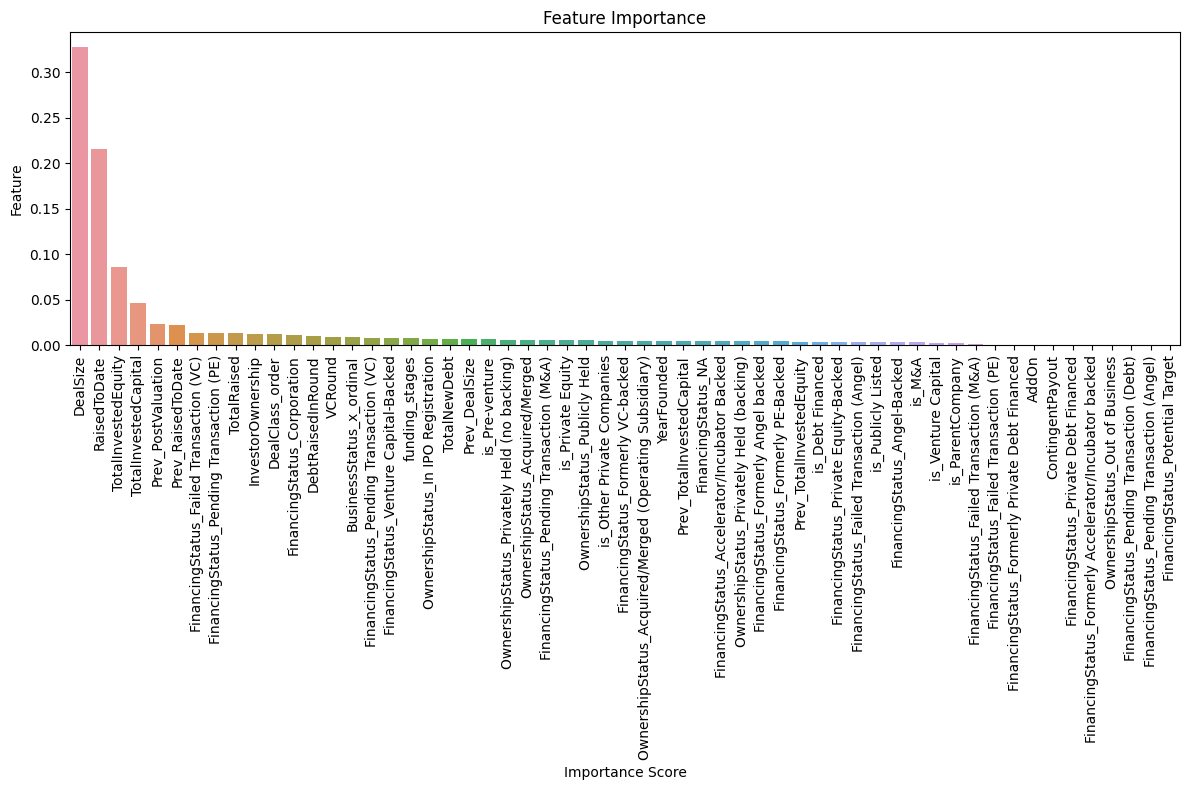

In [112]:
plt.figure(figsize=(12, 8))
feature_importance = pd.DataFrame({"Scores": xgb.feature_importances_, 'Feature': X.columns}).sort_values('Scores', ascending=False).reset_index().drop('index', axis=1)
sns.barplot(y='Scores', x='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.xticks(rotation=90) 
plt.tight_layout()
plt.show()


In [125]:
feature_importance

,Scores,Feature
0,0.392706,DealSize
1,0.273131,RaisedToDate
2,0.090892,TotalInvestedEquity
3,0.079460,TotalInvestedCapital
4,0.028124,Prev_PostValuation
5,0.023725,Prev_RaisedToDate
6,0.019039,InvestorOwnership
7,0.015934,DebtRaisedInRound
8,0.015378,DealClass_order
9,0.014090,FinancingStatus_Failed Transaction (VC)


In [121]:
from xgboost import XGBRegressor
xgb = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

data = df.dropna(subset = ['PostValuation'])
X = data[feature_importance[feature_importance['Scores'] > 0.01]['Feature']]
y = np.log1p(data['PostValuation']) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb.fit(X_train, y_train)
xgb.score(X_test, y_test)


0.9306127289041413

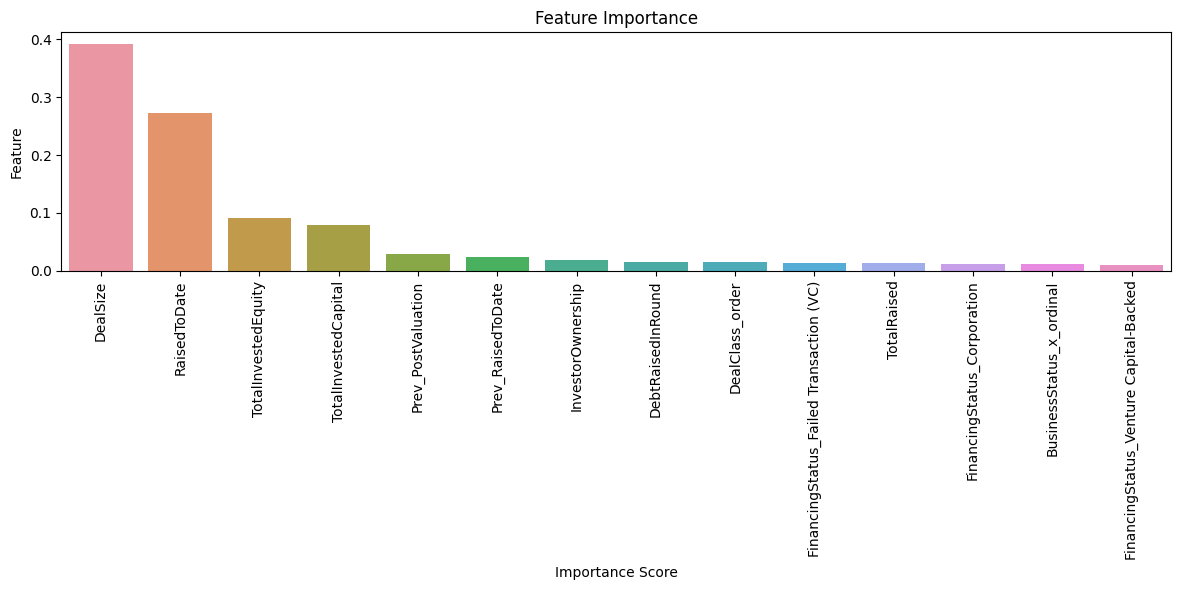

In [122]:
plt.figure(figsize=(12, 6))
feature_importance = pd.DataFrame({"Scores": xgb.feature_importances_, 'Feature': X.columns}).sort_values('Scores', ascending=False).reset_index().drop('index', axis=1)
sns.barplot(y='Scores', x='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.xticks(rotation=90) 
plt.tight_layout()
plt.show()


In [135]:
xgb =XGBRegressor(scale_pos_weight=1, subsample = 0.8)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 10],
    'min_child_weight': [1,5, 10],
    'gamma': [i/10.0 for i in range(0,5)],
    'reg_alpha':[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1],
    'eta': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1],
    'reg_lambda': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
}

grid_search = GridSearchCV(estimator=xgb,param_grid=param_grid,cv=5, n_jobs=-1,verbose=0)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'eta': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1],
                         'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                         'max_depth': [3, 5, 10],
                         'min_child_weight': [1, 5, 10],
                         'n_estimators': [100, 200, 300],
                         'reg_alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1],
                         'reg_lambda': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]})

In [138]:
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'eta': 0.1, 'gamma': 0.0, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 200, 'reg_alpha': 0.5, 'reg_lambda': 1}
Best Score: 0.9377352066473422


In [139]:
xgb_final =XGBRegressor(scale_pos_weight=1, subsample = 0.8, gamma= 0.2, max_depth= 3, min_child_weight= 1, n_estimators= 200, reg_alpha= 0.05)
xgb_final.fit(X_test, y_test)
y_pred = xgb_final.predict(X_test)

print('Final Score:', xgb_final.score(X_test, y_test))
print('Final RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

Final Score: 0.9742953668340407
Final RMSE: 0.2794195257184268


## Lasso Regression

In [176]:
# feature selection with lasso
features_to_transform = []

for i, feature in enumerate(df.select_dtypes('float').columns):
    if df[feature].skew() > 1:
        features_to_transform.append(feature)

In [197]:
data = df.dropna(subset = ['DealSize', 'PercentAcquired', 'PostValuation',
       'RaisedToDate', 'TotalInvestedCapital', 'InvestorOwnership',
       'TotalInvestedEquity', 'TotalNewDebt', 'DebtRaisedInRound',
       'ContingentPayout', 'TotalRaised', 
       'YearFounded', 'Prev_DealSize', 'Prev_RaisedToDate',
       'Prev_TotalInvestedCapital', 'Prev_TotalInvestedEquity',
       'Prev_PostValuation', 'funding_stages', 'BusinessStatus_x_ordinal'])
data[features_to_transform] = np.log1p(data[features_to_transform])
X = data[[
       'DealSize', 'PercentAcquired',
       'RaisedToDate', 'TotalInvestedCapital', 'InvestorOwnership',
       'TotalInvestedEquity', 'TotalNewDebt', 'DebtRaisedInRound',
       'ContingentPayout', 'TotalRaised', 
       'YearFounded', 'Prev_DealSize', 'Prev_RaisedToDate',
       'Prev_TotalInvestedCapital', 'Prev_TotalInvestedEquity',
       'Prev_PostValuation', 'funding_stages', 'BusinessStatus_x_ordinal']]
y = data['PostValuation']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lasso = LassoCV(cv=5).fit(X_train, y_train)
lasso.score(X_test, y_test)

/var/folders/h8/frp0f1bd0v32l04p93kbg3f00000gn/T/ipykernel_50789/3689974776.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[features_to_transform] = np.log1p(data[features_to_transform])


0.8987399778510949

In [198]:
import statsmodels.api as sm
X_train = X_train[X_train.columns[np.where(lasso.coef_ != 0)]]
X_test = X_test[X_test.columns[np.where(lasso.coef_ != 0)]]
X_with_const = sm.add_constant(X_train) 
model = sm.OLS(y_train, X_with_const)   
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          PostValuation   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     1136.
Date:                Thu, 31 Jul 2025   Prob (F-statistic):          1.21e-174
Time:                        09:32:03   Log-Likelihood:                 11.573
No. Observations:                 250   AIC:                            -9.146
Df Residuals:                     243   BIC:                             15.50
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  17.4434    

In [199]:
y_pred = results.predict(sm.add_constant(X_test))

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse}")
print(f"R2: {r2}")

RMSE: 0.4205730958803522
R2: 0.9017938971536581


In [200]:
X = data[[
       'PercentAcquired',
       'RaisedToDate', 
       'TotalInvestedEquity',
       'Prev_PostValuation', ]]
y = data['PostValuation']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_with_const = sm.add_constant(X_train) 
model = sm.OLS(y_train, X_with_const)   
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:          PostValuation   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     1685.
Date:                Thu, 31 Jul 2025   Prob (F-statistic):          6.67e-177
Time:                        09:32:07   Log-Likelihood:                 9.2754
No. Observations:                 250   AIC:                            -8.551
Df Residuals:                     245   BIC:                             9.057
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   2.2617    

In [201]:
y_pred = results.predict(sm.add_constant(X_test))

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Final RMSE: {rmse}")
print(f"Final R2: {r2}")

Final RMSE: 0.43860170219548733
Final R2: 0.893193882580704


## Model Selection
Due to the nature of the data with alot of missingness and many features, I felt like tree-based models would be the most suitable, given their ability to handle missing values, ability to capture non-linearities and handle interaction terms between predictors. Thus, I implemented both a random forest model as well as XGBoost. 

I also fit the data to a linear regression model because it provides a baseline comparison and allows for interpretability of feature effects through coefficients and p-values. While linear models assume additive and linear relationships between predictors and the target, they offer insight into which features are statistically significant and help validate the importance of certain variables under a simpler modeling framework. Despite being less flexible than tree-based methods, linear regression is useful for understanding underlying relationships and benchmarking more complex models.

### Linear Regression 
- Training methodology
I trained a linear regression model with lasso regularization on all my numerical features, and select the most important features determined by coefficients. Lasso’s ability to shrink uninformative coefficients to zero provided a mechanism for feature selection and model simplification. After selecting features with non-zero coefficients,I refit the model using OLS to obtain interpretable estimates and p-values.
- Limitations
One limitation of the linear regression is that it does not handle missing data well, so without all the features being present, the model cannot be used to impute PostValuation. 

### Random Forests
- Training methodology
I fit a random forest with all my features, and select the most important features determined by feature importance score. Those with a feature importance < 0.01 are eliminated. I then performed Gridsearch to tune hyperparameters like max depth, criterion, max features, min samples leaf, number of estimators, and min samples split. 
- Limitations
One limitation of these models is that all entries associated with a Deal Class of Bankruptcy or Out of Business contain missing valuation data, making it impossible for the models to learn from these cases. As a result, predictions for such companies are currently unsupported and should be revisited if valuation data becomes available in the future.
Random Forests are also far less interpretable compared to Linear Regression models, which could be a problem if the model is intended to inform decision-making by stakeholders who require transparency. Besides, random forests performs less well than XGBoost when fine-grained prediction accuracy is needed.

### XGBoost
- Training methodology
I fit the XGBoost with all my features, and select the most important features determined by feature importance score. Those with a feature importance < 0.01 are eliminated. I then performed Gridsearch to tune hyperparameters like learning rate, number of estimators, max depth etc. 
- Limitations
Similar to the random forest, all entries associated with a Deal Class of Bankruptcy or Out of Business contain missing valuation data, making it impossible for the model to learn from these cases. As a result, predictions for such companies are currently unsupported and should be revisited if valuation data becomes available in the future.
XGBoost models are the least interpretable of the 3 models, which could be a problem if the model is intended to inform decision-making by stakeholders who require transparency. Besides, training time for XGBoost is significantly higher than the other 2 models.

